In [2]:
import numpy as np
import pandas as pd
from scipy import stats
from dataclasses import dataclass
from typing import Tuple, Dict, List
import statsmodels.api as sm
from scipy.stats import beta

In [15]:
df = pd.read_csv('torvik_2025-12-10_09-45-44.csv')

In [16]:
def get_adj_metric_pos (df, metric):
    X = sm.add_constant(df['sos'])
    model = sm.OLS(df[metric], X).fit()
    df['Adj ' + metric] = df[metric] + (model.params['sos'] * df['sos'])
    return df
def get_adj_metric_neg (df, metric):
    X = sm.add_constant(df['sos'])
    model = sm.OLS(df[metric], X).fit()
    df['Adj ' + metric] = df[metric] - (model.params['sos'] * df['sos'])
    return df
def harmonic_mean(x,y):
    return ((x*y*2)/(x+y))
def get_beta_value (team_stat, opp_stat, ess: float = 20.0, eps: float = 1e-4):
    """
    Draw Beta samples for two rates, guarding against invalid shape params.
    - clips means to (eps, 1-eps)
    - uses 'ess' (effective sample size) to form alpha/beta so larger ess -> tighter dist
    """
    # Clip to valid probability range
    th = lambda x: float(np.clip(x, eps, 1.0 - eps))
    m_home = th(team_stat)
    m_away = th(opp_stat)

    a_home = max(m_home * ess, eps)
    b_home = max((1.0 - m_home) * ess, eps)
    a_away = max(m_away * ess, eps)
    b_away = max((1.0 - m_away) * ess, eps)

    h = beta.rvs(a_home, b_home, size=1)[0]
    a = beta.rvs(a_away, b_away, size=1)[0]
    return h, a

In [17]:
#Find coefficients to adjust metrics based on SOS
df = get_adj_metric_pos(df, 'OR%')
df = get_adj_metric_pos(df, 'eFG%')
df = get_adj_metric_pos(df, '2p%')
df = get_adj_metric_pos(df, '3P%')
df = get_adj_metric_pos(df, 'TO% Def.')
df = get_adj_metric_pos(df, 'DR%')
df = get_adj_metric_pos(df, 'eFG% Def')
df = get_adj_metric_pos(df, '2p%D')
df = get_adj_metric_pos(df, '3pD%')
df = get_adj_metric_pos(df, 'TO%')

In [18]:
import numpy as np
import pandas as pd
from scipy import stats
from dataclasses import dataclass
from typing import Tuple, Dict, List

@dataclass
class GameResult:
    """Store results from a single game simulation"""
    home_score: float
    away_score: float
    home_fta: float
    away_fta: float
    total_possessions: float
    spread: float
    total: float

class EnhancedBasketballMC:
    """
    Enhanced Monte Carlo simulator for college basketball games
    """
    
    def __init__(self, base_variance: float = 4.5):
        """
        Args:
            base_variance: Standard deviation for outcome distributions
        """
        self.base_variance = base_variance
        
    def simulate_possession_outcome(self, 
                                   team_stats: Dict,
                                   opp_stats: Dict,
                                   game_situation: str = 'normal') -> Dict:
        """
        Simulate a single possession with more granular modeling
        
        Args:
            team_stats: Dictionary of team's offensive stats
            opp_stats: Dictionary of opponent's defensive stats
            game_situation: 'normal', 'close_late', or 'blowout'
        
        Returns:
            Dictionary with possession outcome details
        """

        # Adjust for game situation using the drawn rates
        to_rate = harmonic_mean(team_stats.get('TOR', 0.0), opp_stats.get('TORD', 0.0))
        ftr = team_stats.get('FTR', 0.0)

        if game_situation == 'close_late':
            ftr *= 1.3
            to_rate *= 1.1
        elif game_situation == 'blowout':
            ftr *= 0.7
            to_rate *= 1.2

        # Turnover
        if np.random.random() < to_rate:
            return {'points': 0, 'fta': 0, 'type': 'turnover'}

        # Free throws (use drawn FT%)
        if np.random.random() < ftr * 0.44:
            ft_pct = team_stats.get('FT%', 0.0)
            # sample whether it's 1,2,3 FTA; simplified probabilities (tune later)
            r = np.random.random()
            if r < 0.93:
                fta = 2
            elif r < 0.995:
                fta = 3
            else:
                fta = 1
            made = sum(np.random.random() < ft_pct for _ in range(int(fta)))
            return {'points': made, 'fta': fta, 'type': 'free_throws'}

        # Field goal attempt
        three_pt_rate = team_stats.get('3PR', 0.0)
        if np.random.random() < three_pt_rate:
            three_make_prob = harmonic_mean(team_stats.get('3P%', 0.0), opp_stats.get('3pD%', 0.0))
            if np.random.random() < three_make_prob:
                return {'points': 3, 'fta': 0, 'type': 'three_made'}
            else:
                # offensive rebound chance (use drawn ORB / DR%)
                if np.random.random() < harmonic_mean(team_stats.get('ORB', 0.0), opp_stats.get('DR%', 0.0)):
                    # offensive rebound -> treat as new possession but avoid deep recursion by returning a putback attempt
                    putback_make = 0.25  # putback conversion prob (tune)
                    if np.random.random() < putback_make:
                        return {'points': 2, 'fta': 0, 'type': 'putback_made'}
                    else:
                        return {'points': 0, 'fta': 0, 'type': 'putback_miss'}
                return {'points': 0, 'fta': 0, 'type': 'three_miss'}
        else:
            two_make_prob = harmonic_mean(team_stats.get('2P%', 0.0), opp_stats.get('2pD%', 0.0))
            if np.random.random() < two_make_prob:
                return {'points': 2, 'fta': 0, 'type': 'two_made'}
            else:
                if np.random.random() < harmonic_mean(team_stats.get('ORB', 0.0), opp_stats.get('DR%', 0.0)):
                    putback_make = 0.2
                    if np.random.random() < putback_make:
                        return {'points': 2, 'fta': 0, 'type': 'putback_made'}
                    else:
                        return {'points': 0, 'fta': 0, 'type': 'putback_miss'}
                return {'points': 0, 'fta': 0, 'type': 'two_miss'}
    
    def simulate_game_possession_by_possession(self,
                                              home_stats: Dict,
                                              away_stats: Dict,
                                              expected_possessions: float) -> GameResult:
        """
        Simulate game possession-by-possession for more accuracy
        
        Args:
            home_stats: Home team statistics
            away_stats: Away team statistics  
            expected_possessions: Expected number of possessions per team
        
        Returns:
            GameResult object with detailed outcomes
        """
        home_score = 0
        away_score = 0
        home_fta = 0
        away_fta = 0
        
        # Add some variance to actual possessions
        actual_possessions = int(np.random.normal(expected_possessions, 3))
        actual_possessions = max(60, min(80, actual_possessions))  # Reasonable bounds
        
        for poss in range(actual_possessions):
            # Determine game situation
            score_diff = abs(home_score - away_score)
            poss_remaining = actual_possessions - poss
            
            if poss_remaining < 10 and score_diff < 6:
                situation = 'close_late'
            elif poss_remaining < 15 and score_diff > 15:
                situation = 'blowout'
            else:
                situation = 'normal'
            
            # Home possession
            home_result = self.simulate_possession_outcome(
                home_stats, away_stats, situation
            )
            home_score += home_result['points']
            home_fta += home_result['fta']
            
            # Away possession (if not end of game)
            if poss < actual_possessions - 1:
                away_result = self.simulate_possession_outcome(
                    away_stats, home_stats, situation
                )
                away_score += away_result['points']
                away_fta += away_result['fta']

        
        return GameResult(
            home_score=home_score,
            away_score=away_score,
            home_fta=home_fta,
            away_fta=away_fta,
            total_possessions=actual_possessions,
            spread=away_score - home_score,
            total=home_score + away_score
        )
    
    def run_monte_carlo(self,
                       home_stats: Dict,
                       away_stats: Dict,
                       n_sims: int = 10000,
                       possession_level: bool = False,
                       use_beta_distr: bool = True) -> Dict:
        """
        Run Monte Carlo simulation
        
        Args:
            home_stats: Home team statistics
            away_stats: Away team statistics
            n_sims: Number of simulations to run
            possession_level: If True, simulate possession-by-possession (slower but more accurate)
        
        Returns:
            Dictionary with simulation results and statistics
        """
        results = []
        
        expected_poss = (home_stats['adjt'] + away_stats['adjt']) / 2

        # Build local draws for probabilistic stats (do not overwrite original dicts)
        if not use_beta_distr:
            home_draws = home_stats.copy()
            away_draws = away_stats.copy()
        else:
            home_draws = {}
            away_draws = {}
            for stat in home_stats:
                if stat in ('Team', 'adjt'):
                    # keep non-probability values as-is
                    home_draws[stat] = home_stats[stat]
                    away_draws[stat] = away_stats.get(stat, home_stats[stat])
                else:
                    # If stat missing in opp_stats, fall back to team value (safety)
                    t_val = home_stats.get(stat, 0.0)
                    o_val = away_stats.get(stat, t_val)
                    # Use a small ESS for very noisy metrics; you can tune ESS per-stat later
                    home_draws[stat], away_draws[stat] = get_beta_value(t_val, o_val, ess=20.0)
        
        for _ in range(n_sims):
            if possession_level:
                result = self.simulate_game_possession_by_possession(
                    home_draws, away_draws, expected_poss
                )
            else:
                # Use your existing faster method
                result = self._simulate_game_aggregate(
                    home_draws, away_draws, expected_poss
                )
            results.append(result)
        
        # Convert to arrays for analysis
        spreads = np.array([r.spread for r in results])
        totals = np.array([r.total for r in results])
        home_scores = np.array([r.home_score for r in results])
        away_scores = np.array([r.away_score for r in results])
        
        return {
            'spreads': spreads,
            'totals': totals,
            'home_scores': home_scores,
            'away_scores': away_scores,
            'results': results,
            'summary': {
                'mean_spread': np.mean(spreads),
                'median_spread': np.median(spreads),
                'std_spread': np.std(spreads),
                'mean_total': np.mean(totals),
                'median_total': np.median(totals),
                'std_total': np.std(totals),
                'home_win_prob': np.mean(home_scores > away_scores),
                'percentiles': {
                    'spread': {
                        '5th': np.percentile(spreads, 5),
                        '25th': np.percentile(spreads, 25),
                        '75th': np.percentile(spreads, 75),
                        '95th': np.percentile(spreads, 95)
                    },
                    'total': {
                        '5th': np.percentile(totals, 5),
                        '25th': np.percentile(totals, 25),
                        '75th': np.percentile(totals, 75),
                        '95th': np.percentile(totals, 95)
                    }
                }
            }
        }
    
    def _simulate_game_aggregate(self,
                                home_stats: Dict,
                                away_stats: Dict,
                                expected_possessions: float) -> GameResult:
        """
        Faster aggregate simulation (similar to your current approach)
        """
        # Add variance to possessions
        actual_poss = np.random.normal(expected_possessions, 2.5)
        
        # Calculate expected points per possession for each team
        # (This would use your existing harmonic mean calculations)
        home_ppp = self._calculate_ppp(home_stats, away_stats)
        away_ppp = self._calculate_ppp(away_stats, home_stats)
        
        # Add game-to-game variance
        home_score = np.random.normal(home_ppp * actual_poss, 
                                     self.base_variance)
        away_score = np.random.normal(away_ppp * actual_poss, 
                                     self.base_variance)
        
        return GameResult(
            home_score=home_score,
            away_score=away_score,
            home_fta=0,  # Not calculated in aggregate
            away_fta=0,
            total_possessions=actual_poss,
            spread=away_score - home_score,
            total=home_score + away_score
        )
    
    def _calculate_ppp(self, offense_stats: Dict, defense_stats: Dict) -> float:
        """Calculate points per possession (simplified)"""
        # This would incorporate your existing harmonic mean logic
        efg = (offense_stats['eFG%'] + (1 - defense_stats['eFG% Def'])) / 2
        return efg * 2 * 0.95  # Simplified for example
    
    def calculate_betting_edge(self,
                              sim_results: Dict,
                              vegas_spread: float,
                              vegas_total: float,
                              juice: float = -110) -> Dict:
        """
        Calculate expected value for various betting scenarios
        
        Args:
            sim_results: Results from run_monte_carlo
            vegas_spread: Vegas line for spread
            vegas_total: Vegas line for total
            juice: Standard betting juice (odds)
        
        Returns:
            Dictionary with EV calculations
        """
        spreads = sim_results['spreads']
        totals = sim_results['totals']
        
        # Calculate cover probabilities
        home_cover_prob = np.mean(spreads <= vegas_spread)
        away_cover_prob = 1 - home_cover_prob
        over_prob = np.mean(totals >= vegas_total)
        under_prob = 1 - over_prob
        
        # Convert juice to decimal odds
        if juice < 0:
            decimal_odds = 1 + (100 / abs(juice))
        else:
            decimal_odds = 1 + (juice / 100)
        
        # Calculate EVs
        home_spread_ev = (home_cover_prob * (decimal_odds - 1)) - (1 - home_cover_prob)
        away_spread_ev = (away_cover_prob * (decimal_odds - 1)) - (1 - away_cover_prob)
        over_ev = (over_prob * (decimal_odds - 1)) - (1 - over_prob)
        under_ev = (under_prob * (decimal_odds - 1)) - (1 - under_prob)
        
        return {
            'spread': {
                'home_cover_prob': home_cover_prob,
                'away_cover_prob': away_cover_prob,
                'home_ev': home_spread_ev * 100,  # As percentage
                'away_ev': away_spread_ev * 100
            },
            'total': {
                'over_prob': over_prob,
                'under_prob': under_prob,
                'over_ev': over_ev * 100,
                'under_ev': under_ev * 100
            },
            'recommended_bets': self._get_recommended_bets(
                home_spread_ev, away_spread_ev, over_ev, under_ev
            )
        }
    
    def _get_recommended_bets(self, home_ev, away_ev, over_ev, under_ev) -> List[str]:
        """Return list of recommended bets based on positive EV"""
        recommendations = []
        threshold = 0.1  # 2% edge threshold
        
        if home_ev > threshold:
            recommendations.append(f"HOME SPREAD (EV: {home_ev*100:.1f}%)")
        if away_ev > threshold:
            recommendations.append(f"AWAY SPREAD (EV: {away_ev*100:.1f}%)")
        if over_ev > threshold:
            recommendations.append(f"OVER (EV: {over_ev*100:.1f}%)")
        if under_ev > threshold:
            recommendations.append(f"UNDER (EV: {under_ev*100:.1f}%)")
        
        return recommendations if recommendations else ["NO SIGNIFICANT EDGE"]

def prepare_team_stats_for_mc(df, team_name):
    """
    Extract team stats from dataframe in format needed for Monte Carlo simulation
    
    Args:
        df: Your main dataframe with team statistics
        team_name: Name of the team
    
    Returns:
        Dictionary with properly formatted stats
    """
    team_data = df[df['Team'] == team_name].iloc[0]
    
    return {
        'eFG%': team_data['Adj eFG%']/100,
        'eFG% Def': team_data['Adj eFG% Def']/100,
        'TOR': team_data['Adj TO%']/100,
        'TORD': team_data['Adj TO% Def.']/100,
        'ORB': team_data['Adj OR%']/100,
        'DR%': team_data['Adj DR%']/100,
        '3PR': team_data['3P rate']/100,
        '3P%': team_data['Adj 3P%']/100,
        '3pD%': team_data['Adj 3pD%']/100,
        '2P%': team_data['Adj 2p%']/100,
        '2pD%': team_data['Adj 2p%D']/100,
        'FTR': team_data['FTR']/100,
        'FT%': team_data['ft%']/100,
        'adjt': team_data['adjt']
    }


In [19]:
#Get rows where team has john
df[df['Team'].str.contains('john', case=False)]

,Team,eFG%,eFG% Def,FTR,FTR Def,OR%,DR%,TO%,TO% Def.,3P%,...,Adj OR%,Adj eFG%,Adj 2p%,Adj 3P%,Adj TO% Def.,Adj DR%,Adj eFG% Def,Adj 2p%D,Adj 3pD%,Adj TO%
102,St. John's,53.6,46.7,47.5,31.9,39.1,36.4,17.3,21.8,33.0,...,45.594993,56.232727,57.658976,36.113434,20.865999,38.864746,45.078377,45.053024,30.273706,15.575539


In [54]:
if __name__ == "__main__":
    home_team = "Utah"
    away_team = "Mississippi St."
    home_stats = prepare_team_stats_for_mc(df, home_team)
    away_stats = prepare_team_stats_for_mc(df, away_team)
    
    simulator = EnhancedBasketballMC(base_variance=4.5)
    
    # Run simulation
    results = simulator.run_monte_carlo(
        home_stats, 
        away_stats, 
        n_sims=10000,
        possession_level=True,  # Set to True for more accuracy (slower)
        use_beta_distr=False
    )

    print("Simulation Summary:")
    print(f"Mean Spread (Away - Home): {results['summary']['mean_spread']:.2f}")
    print(f"Median Spread: {results['summary']['median_spread']:.2f}")
    print(f"Spread Std Dev: {results['summary']['std_spread']:.2f}")
    print(f"\nMean Total: {results['summary']['mean_total']:.2f}")
    print(f"Median Total: {results['summary']['median_total']:.2f}")
    print(f"Total Std Dev: {results['summary']['std_total']:.2f}")
    print(f"\nHome Win Probability: {results['summary']['home_win_prob']:.1%}")
    
    # Calculate betting edges
    betting_analysis = simulator.calculate_betting_edge(
        results,
        vegas_spread=-13.5,
        vegas_total=154.5
    )
    
    print("\nBetting Analysis:")
    print(f"Home Cover Prob: {betting_analysis['spread']['home_cover_prob']:.1%}")
    print(f"Over Probability: {betting_analysis['total']['over_prob']:.1%}")
    print("\nRecommended Bets:")
    for bet in betting_analysis['recommended_bets']:
        print(f"  • {bet}")

Simulation Summary:
Mean Spread (Away - Home): -2.88
Median Spread: -3.00
Spread Std Dev: 13.14

Mean Total: 136.63
Median Total: 136.00
Total Std Dev: 14.47

Home Win Probability: 57.3%

Betting Analysis:
Home Cover Prob: 20.7%
Over Probability: 11.0%

Recommended Bets:
  • AWAY SPREAD (EV: 51.4%)
  • UNDER (EV: 69.9%)


Washington
Georgia Tech
Northwestern
Clemson


Long Beach St.

Kentucky
Notre Dame
Samford (blowout)

Iowa St. Cover 4.5 (close once you adjust for home court)
Duke Cover 1.5 (close once you adjust for home court)


Ohio State cover +2.5 (road underdog) - cant bet

Marqueete cover +11.5 (road underdog) - maybe
LaSalle cover +1.5 (home underdog) -    yes
Indiana cover +3.5 (home underdog) - yes
George Mason cover +3.5 - yes
Seton Hall cover +2.5 - yes
Auburn Cover +8.5 - maybe
Asu Cover +5.5 - no

Ole Miss Cover
Florida state cover

12/9:
Clemson cover +5.5 (hit)
Penn St. +14.5 (miss)
UCONN cover -3.5 (hit)

12/10:
New Mexico cover +9.5
Minnesota cover +20.5 (????)
Nebraska cover -2.5





In [100]:
#What are odds Kentucky wins by more than 10

np.mean(results['spreads'] <= -10)  

0.5162

(array([  1.,   1.,   1.,   0.,   1.,   1.,   3.,   6.,  13.,  13.,  18.,
         36.,  53.,  74.,  41.,  86., 101.,  94.,  67.,  96.,  86.,  69.,
         29.,  44.,  25.,  16.,  10.,   8.,   4.,   3.]),
 array([-61.        , -58.13333333, -55.26666667, -52.4       ,
        -49.53333333, -46.66666667, -43.8       , -40.93333333,
        -38.06666667, -35.2       , -32.33333333, -29.46666667,
        -26.6       , -23.73333333, -20.86666667, -18.        ,
        -15.13333333, -12.26666667,  -9.4       ,  -6.53333333,
         -3.66666667,  -0.8       ,   2.06666667,   4.93333333,
          7.8       ,  10.66666667,  13.53333333,  16.4       ,
         19.26666667,  22.13333333,  25.        ]),
 <BarContainer object of 30 artists>)

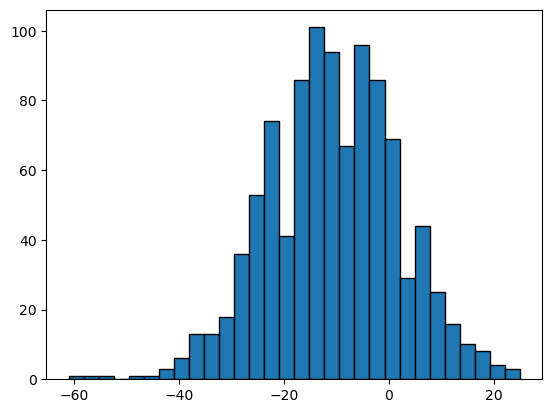

In [82]:
#Graph distribution of spread
import matplotlib.pyplot as plt
plt.hist(results['spreads'], bins=30, edgecolor='black')


Needed Improvements:
- Bring numbers closer to pop mean with less games
- Incorporate defensive impact with harmonic means
- Use SOS to get metrics relative to opponent quality
